# Usage
This code using model at model/static/CNN/BS16/3500_3516/ver3_, using 3p4 GHz dataset  
* Training data was generated by DeepMIMOData/Static_BS16/freq_symb_1ant_612antsub_ver4  
  *      min  = -2.7632e-5
  *      max  = 2.7672e-5
  *      mean = 6.8901e-9  
* Map-based data for inference: CDL Customization/Data/ver3  
    was generated by ETS_CDLcustomize_v8_0_Loop_similar_v713.mlx  
  *      min  = -7.3395e-05
  *      max  = 7.1074e-5
  *      mean = -1.1906e-6

* The model is saved in model/static/CNN/BS16/3500_3516/ver4_

# Normalization method
* The models were trained with data instance min-max normalized, each training sample was scaled according to its min and max 
* This version will also normalize each inference data sample with its min and max
* The output of the CNN will be then de-normalized with the min and max of the input 

In [17]:
import h5py
import torch
import torch.nn as nn
import random


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
from scipy.io import savemat
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('../helper')
from utils import CNN_Est
import loader
import utils


In [18]:
rowss = '3500_3516'
model_path = '../model/static/CNN/BS16/'+ rowss + '/ver5_/'
CDL_path = '../../CDL Customization/Data/ver3/'
SNR = np.arange(0, 31, 5) # 0:5:30 dB
device = 'cpu'
BATCH_SIZE = 32

average_nmse_LS_LI = []     # with length same as length of SNR 
average_nmse_LI_NN = []
average_nmse_LS_NN = []


for snr in SNR:
    # variables = torch.load(model_path + str(snr) + 'dB/CNN_1_variable.pth')

    # trainData_LS_min = variables['train_min_LS']
    # trainData_LS_max = variables['train_max_LS']
    # trainData_LI_min = variables['train_min_LI']
    # trainData_LI_max = variables['train_max_LI']
    # trainLabels_min  = variables['train_label_min']
    # trainLabels_max  = variables['train_label_max']

    model_LS_CNN = CNN_Est()
    checkpoint_LS = torch.load(model_path + str(snr) + 'dB/CNN_1_LS_CNN_model.pth')
    model_LS_CNN.load_state_dict(checkpoint_LS['model_state_dict'])
    model_LS_CNN.eval()

    model_LS_LI_CNN = CNN_Est()
    checkpoint_LI = torch.load(model_path + str(snr) + 'dB/CNN_1_LS_CNN_model.pth')
    model_LS_LI_CNN.load_state_dict(checkpoint_LI['model_state_dict'])
    model_LS_LI_CNN.eval()

    mapBaseData_path = CDL_path + str(snr) + 'dB/1_mapBaseData.mat'
    file = h5py.File(mapBaseData_path, 'r')
    file['H_data'].shape

    H_true = np.empty((0, 2, 612, 14)) # true channel
    H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
    H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
            
    H_true = np.concatenate((H_true, (np.array(file['H_data']))) , axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, (np.array(file['H_equalized_data']))), axis = 0)
    H_linear = np.concatenate((H_linear, (np.array(file['H_linear_data']))), axis=0)

    H_true = torch.from_numpy(H_true)
    H_equal = torch.from_numpy(H_equal)
    H_linear = torch.from_numpy(H_linear)
    
    testData_LS_normd, test_LS_min, test_LS_max = utils.minmaxScaler(H_equal)
    testData_LI_normd, test_LI_min, test_LI_max = utils.minmaxScaler(H_linear)
    
    min_maxLS = torch.stack((test_LS_min, test_LS_max), dim=1)
    min_maxLI = torch.stack((test_LI_min, test_LI_max), dim=1)

    testData_LS_normd = testData_LS_normd.to(device, dtype=torch.float)
    testData_LI_normd = testData_LI_normd.to(device, dtype=torch.float)
    min_maxLS         = min_maxLS.to(device, dtype=torch.float)
    min_maxLI         = min_maxLI.to(device, dtype=torch.float)
                                        
    
    H_true = H_true.to(device, dtype=torch.float)

    # Create a DataLoader for dataset
    test_dataset = TensorDataset(testData_LS_normd, testData_LI_normd, min_maxLS, min_maxLI, H_true)  # [nSamples, 2, 612, 14]
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)   


    with torch.no_grad():
        nmse_LS_LI_SNRi = []    # temp variable to save nmse of batchs of snr_i
        nmse_LS_NN_SNRi = []    # length is same as number of batches
        nmse_LI_NN_SNRi = []
        print(f"SNR: {snr}/{SNR[-1]}")
        for batch_idx, (LS_inputs, LI_inputs, minmaxLS, minmaxLI, test_targets) in enumerate(test_loader):
            # LS_inputs == channel after LS, after normalized
            # LI_inputs == channel after LS+LI, after normalized
            # test_targets == true channel
            if (batch_idx + 1)%5==0:
                print(f" - Batch {batch_idx + 1}/{len(test_loader)}")
            
            LS_inputs_real = LS_inputs[:,0,:,:].unsqueeze(1)
            LS_inputs_imag = LS_inputs[:,1,:,:].unsqueeze(1)
            
            LI_inputs_real = LI_inputs[:,0,:,:].unsqueeze(1)
            LI_inputs_imag = LI_inputs[:,1,:,:].unsqueeze(1)
            
            # 
            test_targets_complex = torch.complex(test_targets[:,0,:,:], test_targets[:,1,:,:])
            
        ##### NMSE of LS+NN
            LS_NN_outputs_real = model_LS_CNN(LS_inputs_real) # 32x1x612x14
            LS_NN_outputs_imag = model_LS_CNN(LS_inputs_imag) 
            LS_NN_outputs = torch.cat((LS_NN_outputs_real, LS_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LS_NN_outputs_denormd = utils.deMinMax(LS_NN_outputs, minmaxLS[:,0], minmaxLS[:,1])
            LS_NN_outputs_complex = torch.complex(LS_NN_outputs_denormd[:,0,:,:], LS_NN_outputs_denormd[:,1,:,:]) # 32x612x14
            # Calculate nmse
            nmse_LS_NN = utils.calNMSE(LS_NN_outputs_complex, test_targets_complex) # size=32 (batch_size)
            nmse_LS_NN_SNRi.append(nmse_LS_NN.cpu().mean())
            
        ##### NMSE of LS+LI
            # De-normalized --> return H_linear back 
            LS_LI_outputs_denormd = utils.deMinMax(LI_inputs, minmaxLI[:,0], minmaxLI[:,1])
            LS_LI_outputs_complex = torch.complex(LS_LI_outputs_denormd[:,0,:,:], LS_LI_outputs_denormd[:,1,:,:])
            # Calculate the nmse
            nmse_LS_LI = utils.calNMSE(LS_LI_outputs_complex, test_targets_complex) # size=32 (batch_size)
            nmse_LS_LI_SNRi.append(nmse_LS_LI.cpu().mean())
            
        ##### NMSE of LS+LI+NN
            LI_NN_outputs_real = model_LS_LI_CNN(LI_inputs_real)    # 32x1x612x14
            LI_NN_outputs_imag = model_LS_LI_CNN(LI_inputs_imag)
            LI_NN_outputs = torch.cat((LI_NN_outputs_real, LI_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LI_NN_outputs_denormd = utils.deMinMax(LI_NN_outputs, minmaxLI[:,0], minmaxLI[:,1])
            LI_NN_outputs_complex = torch.complex(LI_NN_outputs_denormd[:,0,:,:], LI_NN_outputs_denormd[:,1,:,:])
            
            nmse_LI_NN = utils.calNMSE(LI_NN_outputs_complex, test_targets_complex) # size=32 (batch_size)
            nmse_LI_NN_SNRi.append(nmse_LI_NN.cpu().mean())
            
            
        average_nmse_LS_LI.append(sum(nmse_LS_LI_SNRi)/len(nmse_LS_LI_SNRi))
        average_nmse_LS_NN.append(sum(nmse_LS_NN_SNRi)/len(nmse_LS_NN_SNRi))
        average_nmse_LI_NN.append(sum(nmse_LI_NN_SNRi)/len(nmse_LI_NN_SNRi))

SNR: 0/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23
SNR: 5/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23
SNR: 10/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23
SNR: 15/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23
SNR: 20/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23
SNR: 25/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23
SNR: 30/30
 - Batch 5/23
 - Batch 10/23
 - Batch 15/23
 - Batch 20/23


# Results

## True Channel

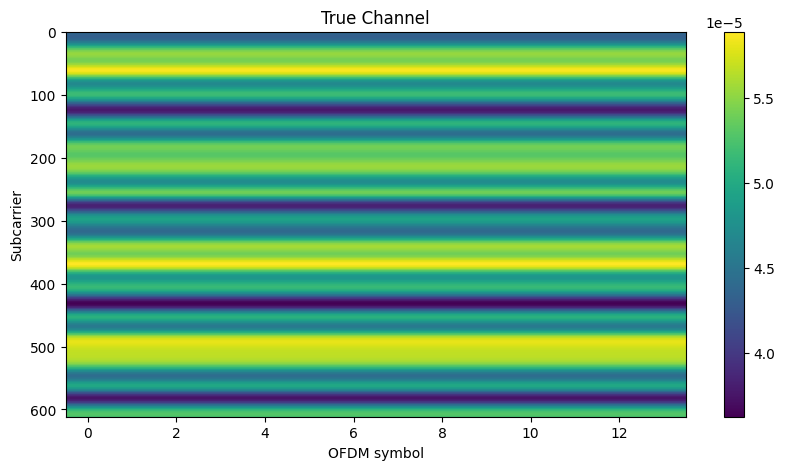

In [19]:

plt.figure(figsize=(10, 5))
plt.imshow(H_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('True Channel')
plt.colorbar()
plt.show()

## Just LS

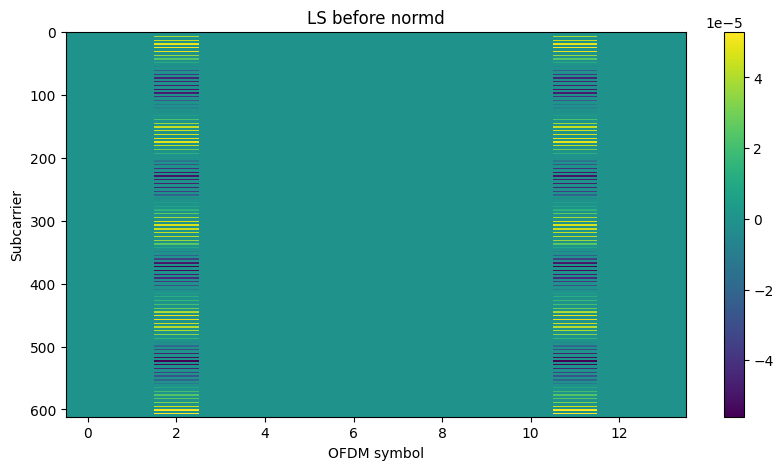

In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(H_equal[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS before normd')
plt.colorbar()
plt.show()

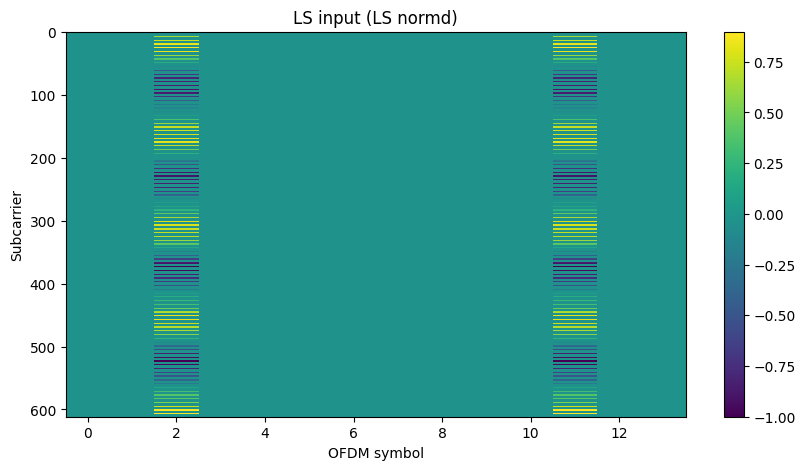

In [21]:

plt.figure(figsize=(10, 5))
plt.imshow(LS_inputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS input (LS normd)')
plt.colorbar()
plt.show()

## LS + CNN

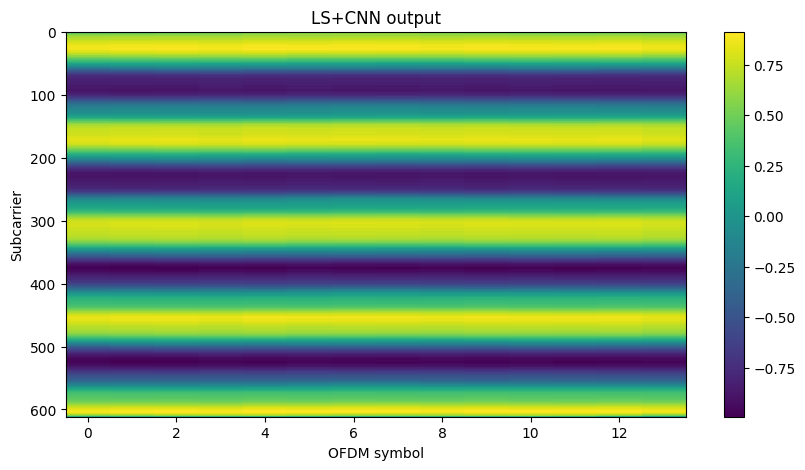

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(LS_NN_outputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+CNN output')
plt.colorbar()
plt.show()

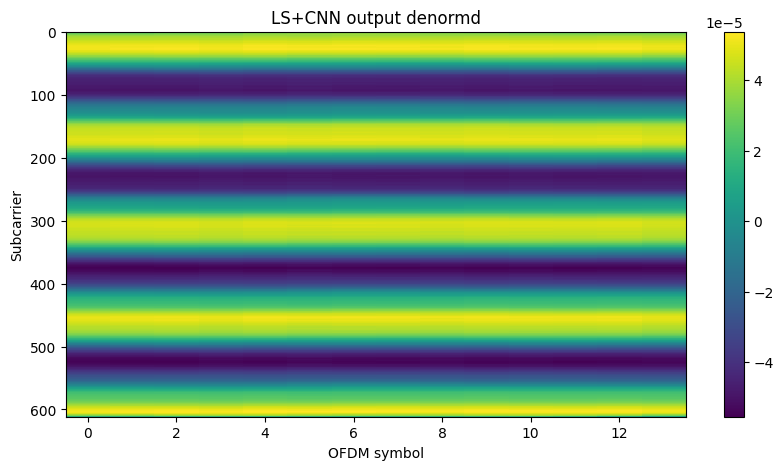

In [23]:
plt.figure(figsize=(10, 5))
plt.imshow(LS_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+CNN output denormd')
plt.colorbar()
plt.show()

## LS+LI

Just need to use H_linear straight

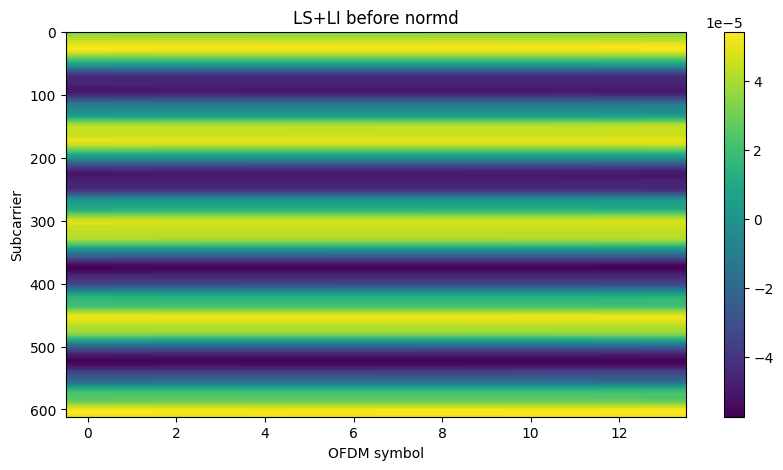

In [24]:
plt.figure(figsize=(10, 5))
plt.imshow(H_linear[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI before normd')
plt.colorbar()
plt.show()

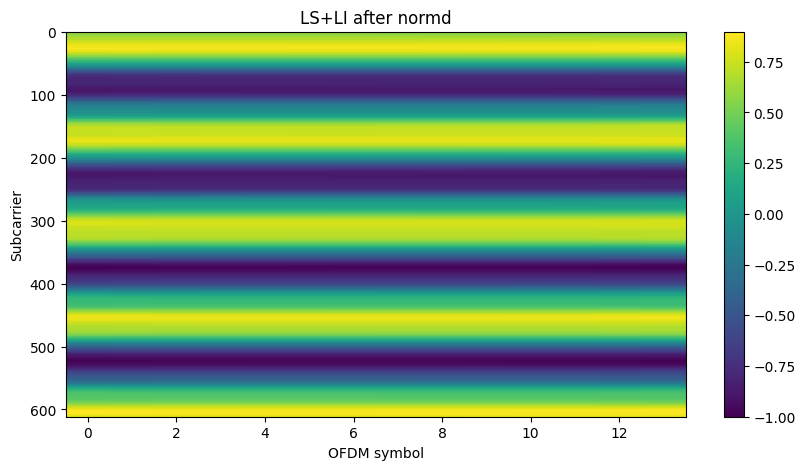

In [25]:
plt.figure(figsize=(10, 5))
plt.imshow(LI_inputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI after normd')
plt.colorbar()
plt.show()

## LS+LI+CNN

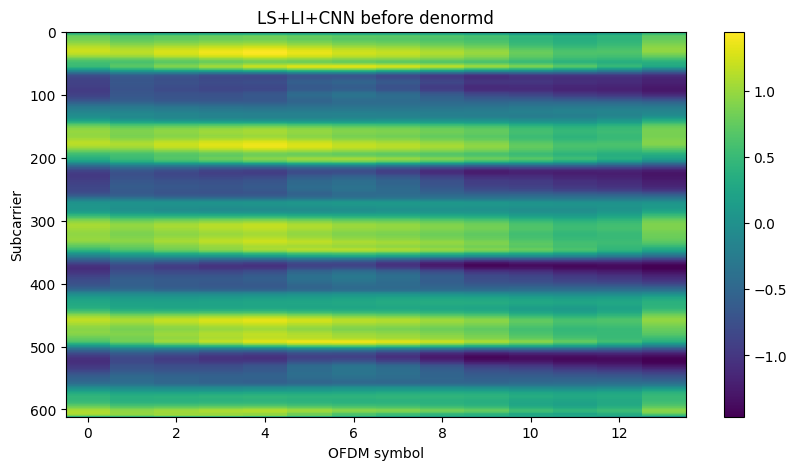

In [26]:
plt.figure(figsize=(10, 5))
plt.imshow(	LI_NN_outputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+CNN before denormd')
plt.colorbar()
plt.show()

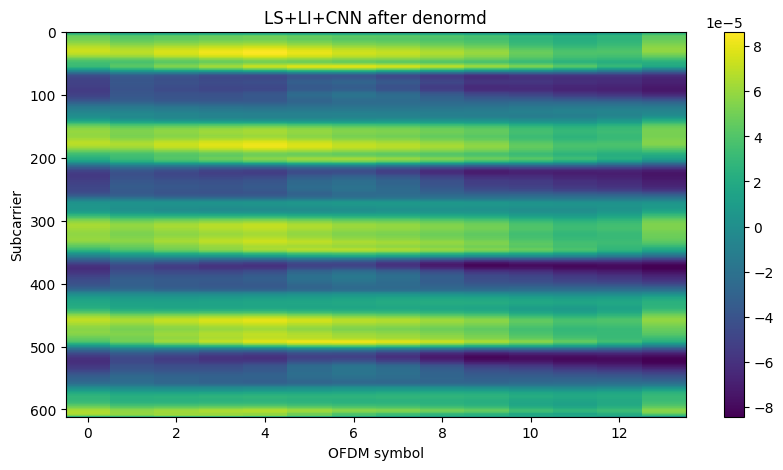

In [27]:
plt.figure(figsize=(10, 5))
plt.imshow(	LI_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+CNN after denormd')
plt.colorbar()
plt.show()

## NMSE

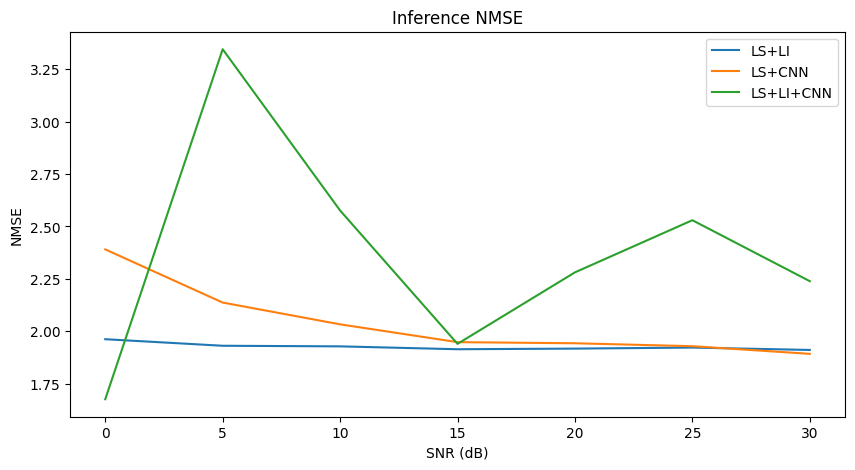

In [28]:
x = [i * 5 for i in range(len(average_nmse_LS_LI))]

plt.figure(figsize=(10, 5))
plt.plot(x, average_nmse_LS_LI, label = 'LS+LI')
plt.plot(x, average_nmse_LS_NN, label = 'LS+CNN')
plt.plot(x, average_nmse_LI_NN, label = 'LS+LI+CNN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Inference NMSE')
plt.legend()
plt.show()

### NMSE only LS+LI

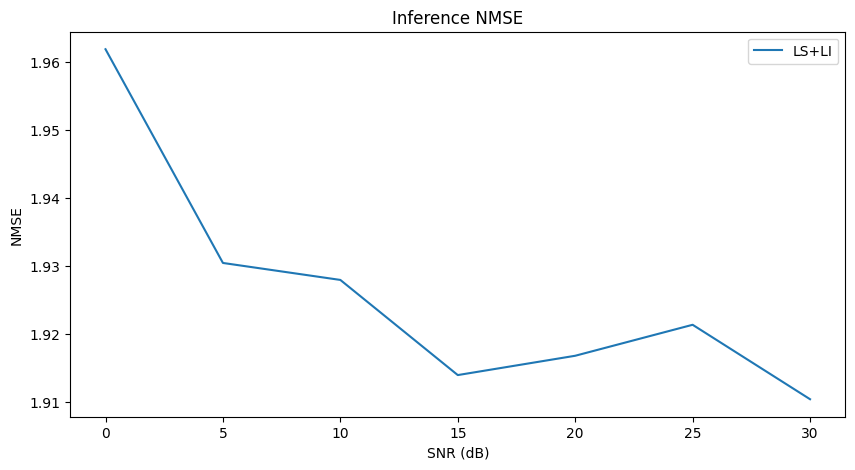

In [29]:
temp = []
for snr in SNR:
    mapBaseData_path = CDL_path + str(snr) + 'dB/1_mapBaseData.mat'
    file = h5py.File(mapBaseData_path, 'r')
    file['H_data'].shape

    H_true = np.empty((0, 2, 612, 14)) # true channel
    H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
            
    H_true = np.concatenate((H_true, (np.array(file['H_data']))) , axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_linear = np.concatenate((H_linear, (np.array(file['H_linear_data']))), axis=0)
    
    H_true = torch.from_numpy(H_true)
    H_linear = torch.from_numpy(H_linear)
    
    H_true_complex = torch.complex(H_true[:,0,:,:], H_true[:,1,:,:])
    H_linear_complex = torch.complex(H_linear[:,0,:,:], H_linear[:,1,:,:])
    
    nmse_snr_i = utils.calNMSE(H_linear_complex, H_true_complex) # size=32 (batch_size)
    temp.append(nmse_snr_i.cpu().mean())
    
plt.figure(figsize=(10, 5))
plt.plot(x, temp, label = 'LS+LI')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Inference NMSE')
plt.legend()
plt.show()